## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

# Generates a totally straight test_road
test_road = np.ones((100,2))
for i in range(100):
    test_road[i,0] = i
    
# Flips the test road, so the car goes from the end to the start.
#test_road = np.flip(test_road, 0)

test_road_width = 5.0*np.ones(np.size(test_road)//2)

## Initialize the car and road model

In [2]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
step = 0.075
N = 30
car = KinematicBicycleCar(N=N, step=step)
car.lr += 0.5 # distance from CG to back wheels
car.lf -= 0.5 # distance from CG to front wheels
DESIRED_SPEED = 4.0

In [3]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [4]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

In [5]:
# stop sign test
stop_sign = (30.0,1.0) # x,y
stop_s = roadrunner.find_closest(stop_sign)

def dist_to_stop_line(xy):
    x0, y0 = stop_sign
    x,y = xy
    dist = np.sqrt((y-y0)**2 + (x-x0)**2)*np.cos(np.arctan2(y0-y, x0-x))
    return dist

stop_dist = 0.0 # meters, distance to stop sign when we should stop

def desired_speed(k:int, xy:np.array):
    xy = np.reshape(xy, (2,))
    # 1: Find closest point to xy on road centerline
    #s = roadrunner.find_closest(xy)
    dist = dist_to_stop_line(xy)
    # 2: Find distance of that point to some set point
    # the distance along the curve is s* curve length
    # 3: Linear relationship between distance and
    if dist > 10:
        return DESIRED_SPEED
    #elif (dist-stop_dist)/10 > 0.25:
    #    return DESIRED_SPEED*( 0.5*(np.tanh(4.0*(dist-stop_dist)/10.0-1)+1))
    #else:
    #    return np.max([0, 2*DESIRED_SPEED*(dist-stop_dist)/10.0])
    else:
        return np.max([0, DESIRED_SPEED*(dist-stop_dist)/10.0])



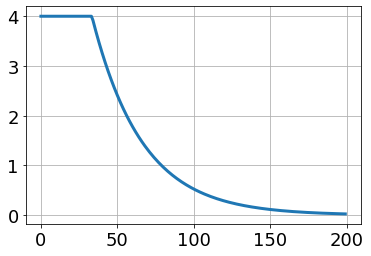

In [6]:
speeds = []
xs = []; ys = []
roadrunner.reset()
roadrunner.advance(10)
for i in range(200):
    xy = roadrunner.evaluate()
    xs.append(xy[0,0]), ys.append(xy[0,1])
    v = desired_speed(0, xy)
    speeds.append(v)
    roadrunner.advance(step*v)
fig, ax = plt.subplots(1,1)
ax.plot(speeds)
plt.show()

## Run the MPC algorithm

In [7]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic, desired_speed, roadrunner)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car, roadrunner,  )
#mpcprob = MpcProblem(KinematicBicycle("base_vehicle_model.json"),
#                                      roadrunner,step, N, desired_speed )
print(desired_speed(0, ic[0:2]))

Starting at initial conditions [6.000000000000024, 1.0, 4.0, 0.0]
4.0


<IPython.core.display.Javascript object>


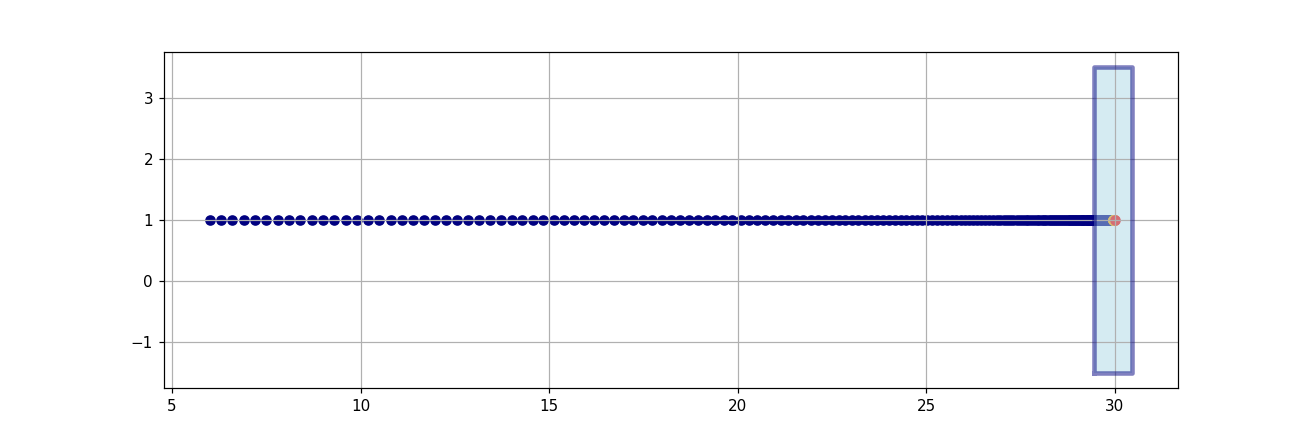

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:405: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [8]:
%matplotlib notebook

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 200

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
centers = np.zeros((4,n_runs+1)) # store the state as simulated for each control input by an integrator
centers[:,0] = [ic[0], ic[1], ic[3], ic[2]] # stupid indexing difference, sorry
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+N,4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(x_true[0,0], x_true[1,0], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0

try:
    while k < n_runs:
        # Solve the MPC problem
        xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
        
        # for plotting
        centers[:,k+1] = mpcprob.x_center_plot[:,1]
        
        
        # Save the next state x_k+1 and control u_k+1
        for i in range(mpcprob.model.n):
            x_plan[i,k+1] = xk_opt[i][1]
        for i in range(mpcprob.model.m):
            u_plan[i,k] = uk_opt[i][1]
        x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

        # Compute distance traveled (approximately)
        step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2)

        # Save the 4 points that represent the polygon boundary at state k
        bounds,p = roadrunner.bound_x(mpcprob.model.step,0, desired_speed)
        polygon_boundaries[k,:,:] = p
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())


        # Plot arrows and x-y states
        ax_traj.clear()
        ax_traj.scatter(x_true[0,:k], x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        ax_traj.scatter(xy[0], xy[1], color="red")
        # Plot the polygon fill
        ax_traj.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)

        # Plot the plan
        #for r in range(30-1):
        #    ax_traj.plot(np.concatenate([mpcprob.p_plot[r,:,0],mpcprob.p_plot[r,0:1,0]]),
        #            np.concatenate([mpcprob.p_plot[r,:,1],mpcprob.p_plot[r,0:1,1]]),
        #            color="navy", alpha=0.2)
        #ax_traj.plot(np.concatenate([mpcprob.p_plot[-1,:,0],mpcprob.p_plot[-1,0:1,0]]),
        #            np.concatenate([mpcprob.p_plot[-1,:,1],mpcprob.p_plot[-1,0:1,1]]),
        #            color="red", alpha=0.2)


        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")
        ax_traj.scatter(stop_sign[0], stop_sign[1], color="red")

        #roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1
        
        # stop sign test??
        idx = xk_opt[0].size-1
        xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]])
        dist = dist_to_stop_line(xy_last)
        print("\n\ndist", dist)
        mpcprob.indices_to_stop = None
        while dist <= stop_dist and idx >= 0:
            mpcprob.indices_to_stop = idx
            
            print("\n\nStopping index", idx)
            idx -= 1
            xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]]) 
            dist = dist_to_stop_line(xy_last)
        
        # restart test??
        if mpcprob.indices_to_stop == 0: # car is at a stop
            # now begin moving forward
            mpcprob.indices_to_stop = None

            mpcprob.indices_to_start = N-1
            
        if mpcprob.indices_to_start is not None:
            mpcprob.indices_to_start -= 1

            if mpcprob.indices_to_start < 0:
                mpcprob.indices_to_start = None


except OutOfRoadPointsException as e:
    print(e)
    x_plan = x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
    u_plan = u_plan[:,:k]  
    x_true = x_true[:,k+1]
    centers = centers[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
finally:
    fig_traj.canvas.draw()


In [9]:
# turn interactive off
plt.ioff()
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[k-1:k+mpcprob.model.N,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


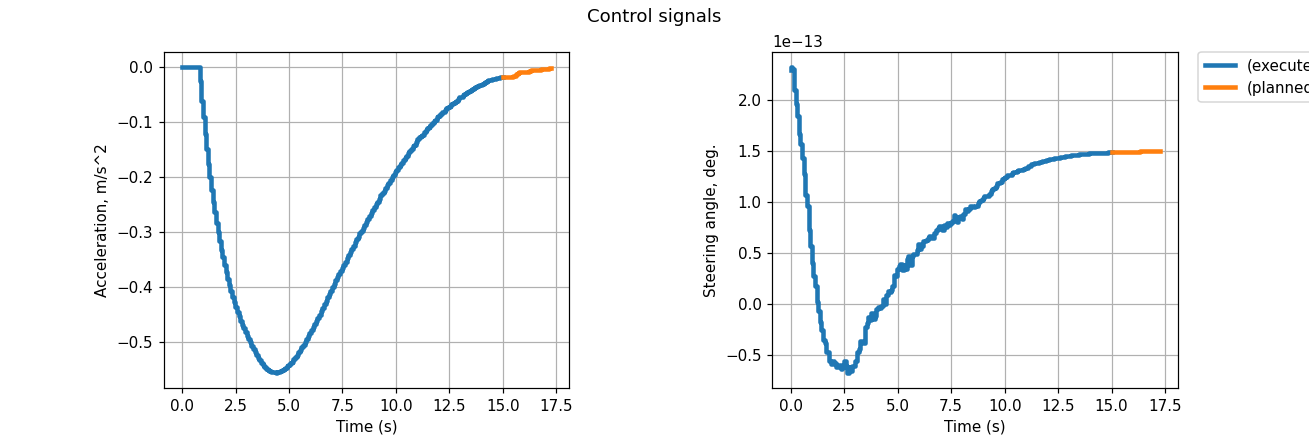

In [10]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(u_plan, mpcprob.u_opt, step, N)
plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

<IPython.core.display.Javascript object>


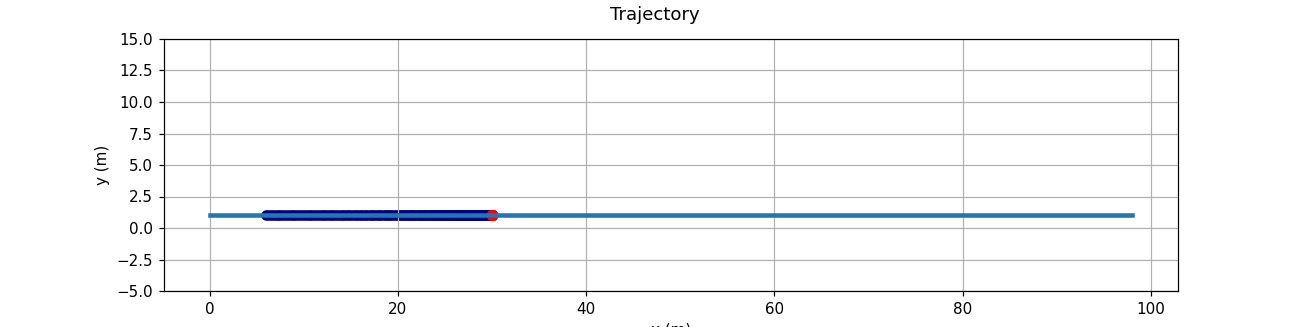

In [11]:
from KinematicBicycleCar import plot_x
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt, step, N, figsize=(12,3))
    
roadrunner.plot(ax=x_ax, n_points=50)
plt.ylim(-5,15)
plt.show()

## x vs time and y vs time, separately, with the boundaries

<IPython.core.display.Javascript object>


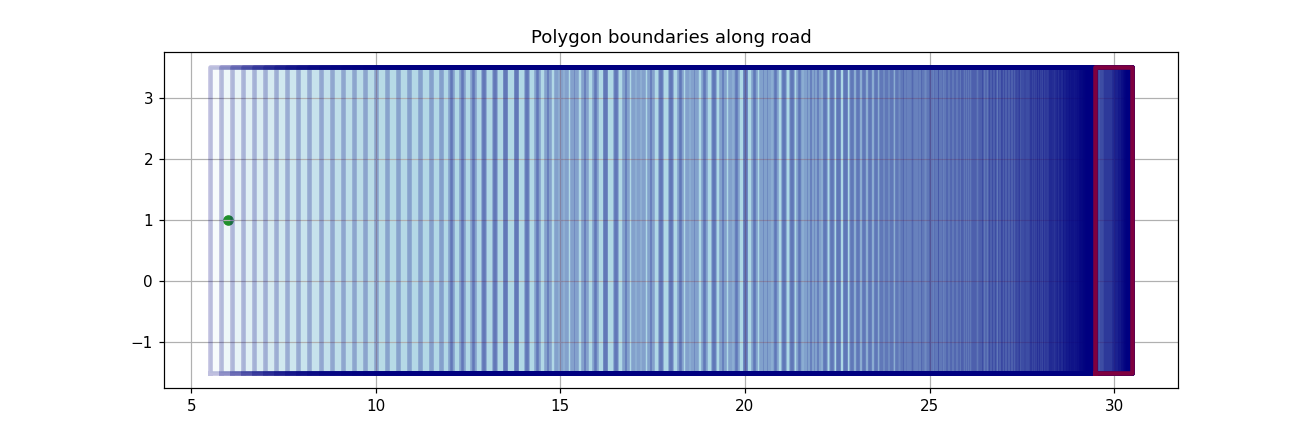

In [12]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1)
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.25)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=0.5)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()

<IPython.core.display.Javascript object>


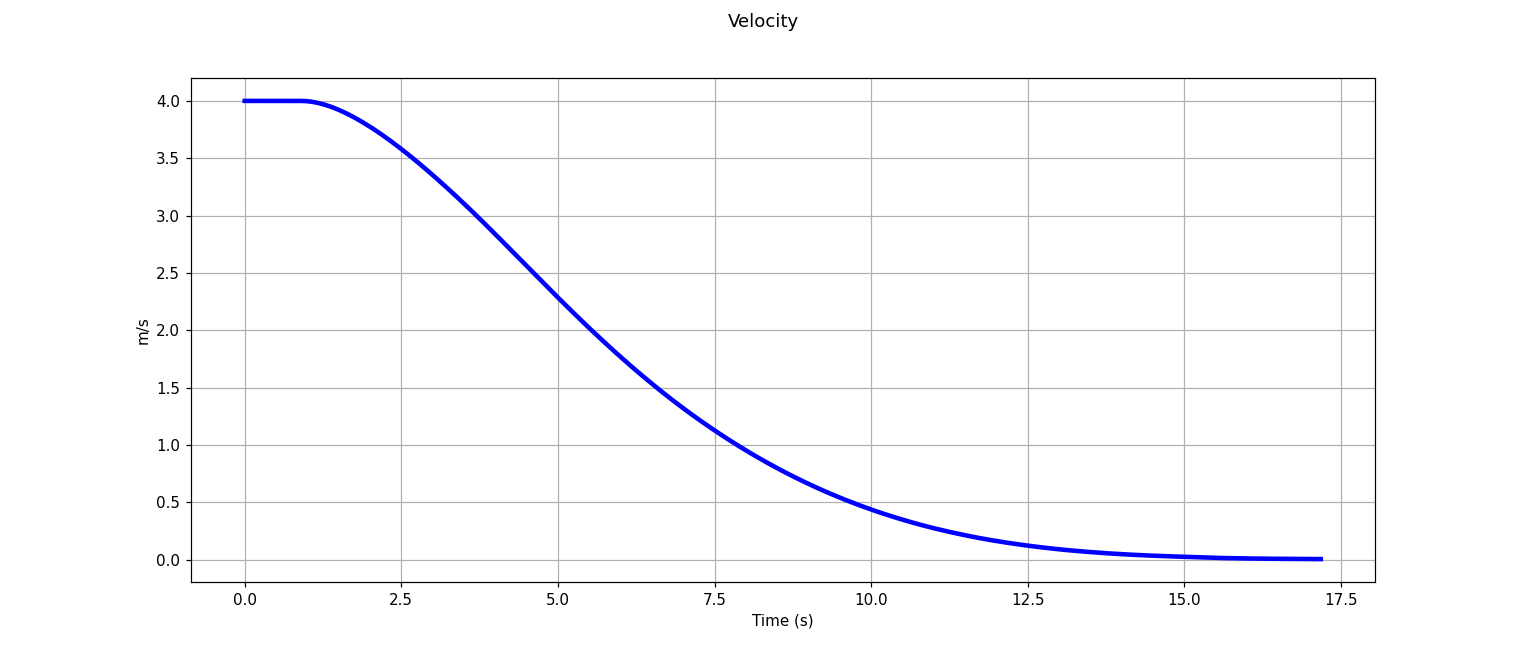

In [13]:
def plot_x(x_executed:np.array, x_planned:np.array):
    fig2, ax = plt.subplots(1,1,
        figsize=(14, 6))

    # Plot the last optimal path computed
    tgrid = np.linspace(0, mpcprob.model.T, mpcprob.model.N)
    vx_plan = np.multiply(x_planned[2],np.cos(x_planned[3]))
    vy_plan = np.multiply(x_planned[2],np.sin(x_planned[3]))

    # Plot the x given
    tgrid = np.linspace(0, mpcprob.model.T, len(x_executed[0]))
    vx_exec = np.multiply(x_executed[2],np.cos(x_executed[3]))
    vy_exec = np.multiply(x_executed[2],np.sin(x_executed[3]))
    # The first 2 states in the planned vector are also in the executed vector
    # since the first state is the initial state (the one we were at)
    # and the second one gets executed, therefore stored in the executed vector
    # to become the next run's initial state. This is why we slice vx_plan, vy_plan.
    vx = np.concatenate([vx_exec, vx_plan[2:]])
    vy = np.concatenate([vy_exec, vy_plan[2:]])
    ax.plot(np.arange(0, vx.size)*step, np.sqrt(vx**2 + vy**2), color="blue")
    
    xs = np.concatenate([x_executed[0], x_planned[0,2:]])
    
    fig2.suptitle("Velocity")
    plt.xlabel("Time (s)"); plt.ylabel("m/s")
    return fig2, ax
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt)
plt.show()

In [14]:
for x in np.transpose(x_plan):
    print("["+",".join([str(xi) for xi in x])+"],")
for x in np.transpose(mpcprob.x_opt):
    print("["+",".join([str(xi) for xi in x])+"],")
    

[6.000000000000024,1.0,4.0,0.0],
[6.3000000000000265,0.9999999999999991,4.0000000000002425,2.5271989018055583e-16],
[6.599999278912439,0.9999999999999996,3.9999807709975794,5.058345604459367e-16],
[6.899996103948895,1.0000000000000002,3.999947708464114,7.601124878039496e-16],
[7.199990865274742,1.000000000000001,3.9999166084408393,1.0003966663979061e-15],
[7.499983463136049,1.0000000000000018,3.9998864762020987,1.2162592763200038e-15],
[7.799973834639969,1.000000000000002,3.9998558329003564,1.4178825809554715e-15],
[8.099961932874788,1.0000000000000033,3.9998260254561377,1.6036884180315835e-15],
[8.399947872743812,1.0000000000000047,3.9997968533566324,1.7728387481528939e-15],
[8.699931590754469,1.0000000000000049,3.9997675758793965,1.9310758571600555e-15],
[8.999913150193944,1.0000000000000058,3.9997390357764075,2.0723323141209457e-15],
[9.299892572606995,1.0000000000000062,3.9997103915403445,2.192550921062024e-15],
[9.599869877037396,1.0000000000000073,3.999683098960954,2.294213269436

In [15]:
for x in np.transpose(u_plan):
    print("["+",".join([str(xi) for xi in x])+"],")
for x in np.transpose(mpcprob.u_opt):
    print("["+",".join([str(xi) for xi in x])+"],")
    

[1.9055659359278136e-12,3.999007654839535e-15],
[-0.00034402107337780754,4.046239670062481e-15],
[-0.00037996528547452305,4.0178078170703995e-15],
[-0.00039106781485165446,3.6541124877455295e-15],
[-0.0003923897821416721,3.411679603989562e-15],
[-0.00040970911285369695,3.222124707892081e-15],
[-0.00038794510495358277,2.902699856944139e-15],
[-0.0003942945254295424,2.7439506541544395e-15],
[-0.00038866181516714147,2.5028705559949282e-15],
[-0.00037922158892740457,2.2235190802273324e-15],
[-0.00038554129252910493,1.8674698164947037e-15],
[-0.00035550167736363733,1.6722092700841696e-15],
[-0.025242377912501734,1.2683814186818332e-15],
[-0.06049443911620371,9.98531997477197e-16],
[-0.09035040488832363,7.081784573675111e-16],
[-0.12121138855775627,4.798650506377491e-16],
[-0.1493510487338862,3.1399644782440753e-16],
[-0.1759198292394883,3.5119201605464225e-17],
[-0.2001876959836179,-1.1523507318973669e-16],
[-0.2235793042213792,-3.0286384988331816e-16],
[-0.24453696622175927,-4.344779002670